<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Training-and-Visualizing-a-Decision-Tree" data-toc-modified-id="Training-and-Visualizing-a-Decision-Tree-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training and Visualizing a Decision Tree</a></span></li><li><span><a href="#Making-Predictions" data-toc-modified-id="Making-Predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Making Predictions</a></span></li><li><span><a href="#Estimating-Class-Probabilities" data-toc-modified-id="Estimating-Class-Probabilities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Estimating Class Probabilities</a></span></li><li><span><a href="#The-CART-Training-Algorithm" data-toc-modified-id="The-CART-Training-Algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The CART Training Algorithm</a></span></li><li><span><a href="#Regularization-Hyperparameters" data-toc-modified-id="Regularization-Hyperparameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Regularization Hyperparameters</a></span></li><li><span><a href="#Regression" data-toc-modified-id="Regression-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Regression</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
from graphviz import Source
import numpy as np

# Training and Visualizing a Decision Tree

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [3]:
iris = load_iris()
X = iris.data[:, 2:]
y = iris.target 

In [4]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [5]:
from sklearn.tree import export_graphviz

In [6]:
export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

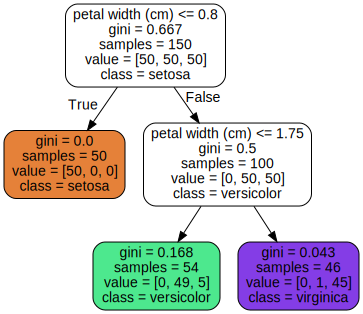

In [7]:
! dot -Tpng iris_tree.dot -o iris_tree.png 
Source.from_file("iris_tree.dot")

# Making Predictions

**Gini Impurity**

$G_{i} = 1 - \sum_{k=1}^{n} P_{i,k}^{2}$

* $P_{i, k}$  is the ratio of class $k$ instances among the training instances in the $i^{th}$ node.

**Entropy**

$H_{i} = - \sum^n_{k=1, P_{i,k} \neq 0} P_{i, k} \log_2(P_{i,k})$

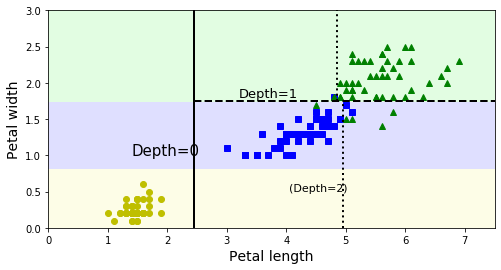

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

# Estimating Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class $k$: first it traverses the tree to find the leaf node for this instance, and then it
returns the ratio of training instances of class $k$ in this node. For example, suppose you have found a flower whose petals are $5 cm$ long and $1.5 cm$ wide. The corresponding leaf node is the depth-2 left node, so the Decision Tree should output the
following probabilities: $0 \%$ for Iris-Setosa (0/54), $90.7 \%$ for Iris-Versicolor (49/54), and $9.3 \%$ for Iris-Virginica (5/54). 

In [9]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [10]:
tree_clf.predict([[5, 1.5]])

array([1])

# The CART Training Algorithm

***CART cost function for classification***

The idea is really quite simple: the algorithm first splits the training set in two subsets using a single feature k and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). How does it choose $k$ and $t_k$ ? It searches for the pair $(k, t_k)$ that produces the purest subsets (weighted by their size). 

***$J(k, t_k) = \frac{m_{left}}{m} G_{left} + \frac{m_{right}}{m} G_{right}$***

***where $G_{left/right}$ :- measures the impurity of the left/right subset***

***$m_{left/right}$ :- is the number of instances in the left/right subset.***

CART algorithm is a **greedy algorithm**.
Unfortunately, finding the optimal tree is known to be an ***NP Complete problem***: it requires $O(exp(m))$ time

# Regularization Hyperparameters

***Hyperparameters:*** **max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, and max_leaf_nodes**


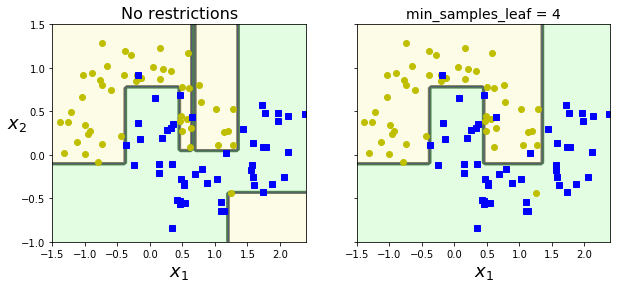

In [11]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()

# Regression

In [12]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [13]:
from sklearn.tree import DecisionTreeRegressor

In [14]:
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

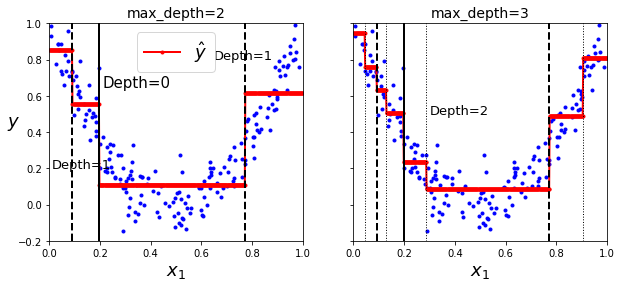

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [16]:
export_graphviz(
        tree_reg1,
        out_file="regression_tree.dot",
        feature_names=["x1"],
        rounded=True,
        filled=True
)

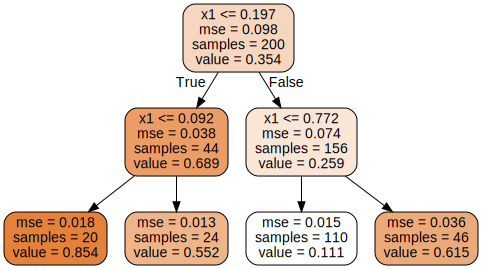

In [17]:
! dot -Tpng regression_tree.dot -o regression_tree.png 
Source.from_file("regression_tree.dot")

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE

***CART Cost function for regression***

$J(k, t_k) = \frac{m_{left}}{m} G_{left} + \frac{m_{right}}{m} G_{right}$

**where**


$ MSE_{node} = \sum{i \in node} (\hat{y} - y^{(i)}) ^ 2$


$\hat{y}_{node} \frac{m_{left}}{m} \sum{i \in node} y^{(i)}$

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. 

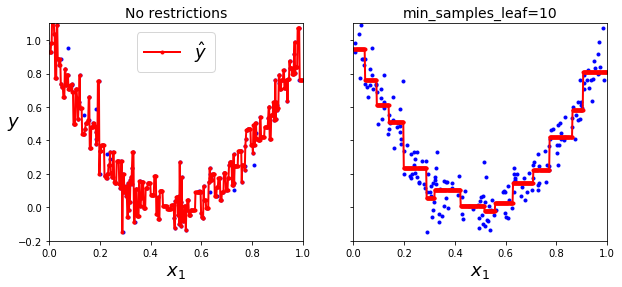

In [18]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)
plt.show()

____

In [19]:
import pandas as pd

In [20]:
data = pd.read_csv("data.csv")

In [21]:
data = data.drop(data.columns[0], axis=1)

In [22]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

In [23]:
X

,Outlook,Temp.,Humidity,Wind
0,Sunny,Hot,High,Weak
1,Sunny,Hot,High,Strong
2,Overcast,Hot,High,Weak
3,Rain,Mild,High,Weak
4,Rain,Cool,Normal,Weak
5,Rain,Cool,Normal,Strong
6,Overcast,Cool,Normal,Strong
7,Sunny,Mild,High,Weak
8,Sunny,Cool,Normal,Weak
9,Rain,Mild,Normal,Weak


In [24]:
X["Outlook"] = X["Outlook"].replace({'Sunny': 1, "Overcast":2, "Rain":3})
X["Temp."] = X["Temp."].replace({"Hot": 1, "Mild": 2, "Cool": 3})
X["Humidity"] = X["Humidity"].replace({"High": 1, "Normal": 2})
X["Wind"] = X["Wind"].replace({"Weak": 1, "Strong": 2})


X

C:\Users\batman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\batman\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\batman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,Outlook,Temp.,Humidity,Wind
0,1,1,1,1
1,1,1,1,2
2,2,1,1,1
3,3,2,1,1
4,3,3,2,1
5,3,3,2,2
6,2,3,2,2
7,1,2,1,1
8,1,3,2,1
9,3,2,2,1


In [25]:
X

,Outlook,Temp.,Humidity,Wind
0,1,1,1,1
1,1,1,1,2
2,2,1,1,1
3,3,2,1,1
4,3,3,2,1
5,3,3,2,2
6,2,3,2,2
7,1,2,1,1
8,1,3,2,1
9,3,2,2,1


In [26]:
y

0      No
1      No
2     Yes
3     Yes
4     Yes
5      No
6     Yes
7      No
8     Yes
9     Yes
10    Yes
11    Yes
12    Yes
13     No
Name: Decision, dtype: object

In [27]:
y = y.replace({"No": 1, "Yes": 2})

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
t = DecisionTreeClassifier()
t.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [30]:
export_graphviz(
    t,
    out_file="test.dot",
    feature_names=X.columns,
    class_names=["No", "Yes"],
    rounded=True,
    filled=True
)

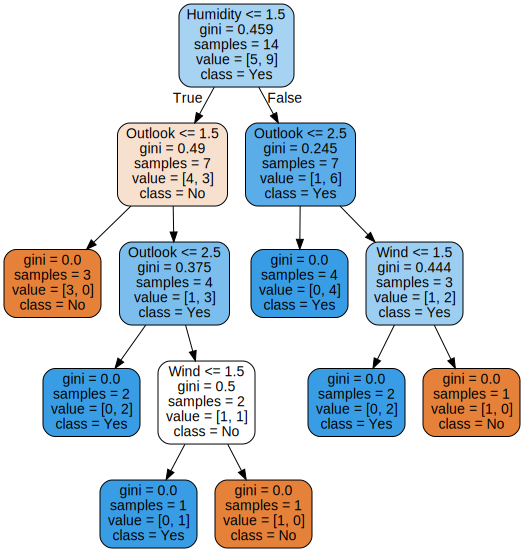

In [31]:
! dot -Tpng test.dot -o test.dot.png 
Source.from_file("test.dot")